In [1]:
#Packages
import pandas as pd
import numpy as np

import matplotlib.font_manager
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import matplotlib.animation

from scipy import io
import math as m 
import csv
import time

from numpy import pi, cos, sin, sign

import pylab
from mayavi import mlab
from pyquaternion import Quaternion
from scipy.stats import binned_statistic as bstat
from scipy.spatial.transform import Rotation as R
import quaternion

import seaborn as sns

contents = io.loadmat('pData_mat.mat') #pData 1,50,20000
pData=contents['pData']
pData.shape

(20, 20000, 49)

In [2]:
def readData(filename, startN, endN, maxParticles):
    NF = 20 #Number of data fields
    
    dt = np.dtype(np.float32)
    f = open(filename, "rb")

    p_data = np.zeros([NF,maxParticles,endN-startN])
    
    f.seek(0)
    for i in range(endN-startN):
        numParticles = np.fromfile(f, dtype=dt, count=1)
        time = np.fromfile(f, dtype=dt, count=1)
        temp = np.fromfile(f, dtype=dt, count=NF*int(numParticles)).reshape((int(numParticles), NF)).transpose()
        p_data[:,0:temp.shape[1],i] = temp
        del temp
    return p_data
pData = readData('output_4_2__2_10mm_Rods.dat', 1, 50, 20000)
pData.shape

(20, 20000, 49)

# Orientation and Rendering

Two Particles:
- Blue disks: d=6.35mm; l=3.175mm; SE_a = 0.002
- Red rods: d=3.175mm; l=4.75mm; SE_a = 0.001



# Plot Overlay of Rotated Particle

In [3]:
def drawParticle_overlay(particle_id, frame):
    
    a, b, c = pData[11,particle_id,frame], pData[12,particle_id,frame], pData[13,particle_id,frame]
    a_2, b_2, c_2 = pData[11,particle_id,frame], pData[12,particle_id,frame], pData[13,particle_id,frame]
    s, t = 2, 8
    q0 = pData[16, particle_id, frame]
    q1 = pData[17, particle_id, frame]
    q2 = pData[18, particle_id, frame]
    q3 = pData[19, particle_id, frame]
    q = R.from_quat([q0,q1,q2,q3])
    M = q.as_matrix()
#     q = Quaternion(q0,q1,q2,q3)
#     M = q.rotation_matrix
    
    x_0,y_0,z_0=0,0,0
    x, y, z = np.ogrid[-0.005:0.005:100j, -0.005:0.005:100j, -0.005:0.005:100j]
    F = abs(abs(x/a)**s+abs(y/b)**s)**(t/s)+abs(z/c)**t-1
    F_r = ((((M[0][0]*(x-x_0)+M[1][0]*(y-y_0)+M[2][0]*(z-z_0))/a)**s) + (((M[0][1]*(x-x_0)+M[1][1]*(y-y_0)+M[2][1]*(z-z_0))/b)**s))**(s/t)+(((M[0][2]*(x-x_0)+M[1][2]*(y-y_0)+M[2][2]*(z-z_0))/c)**t)-1
#     F_r = ( ((((R[0][0]*x)+(R[1][0]*y)+(R[2][0]*z))/a)**s) + (((R[0][1]*x)+(R[1][1]*y)+(R[2][1]*z))/b)**s )**(s/t) + (((R[0][2]*x)+(R[1][2]*y)+(R[2][2]*z))/c)**(t) - 1
    mlab.contour3d(F,contours=[0], transparent=True)
    mlab.contour3d(F_r,contours=[0],color=(0.2, 0.4, 0.5))

    mlab.axes()
    mlab.outline()
    return mlab.show()

In [ ]:
drawParticle_overlay(14,48)

# Compare Euler Angles

In [18]:
frame = 47
i = 3 #particle

xp=pData[2,i,frame]
zp=pData[3,i,frame]
yp=pData[4,i,frame]

vp=pData[5,i,frame]
wp=pData[6,i,frame]
up=pData[7,i,frame]

omgx=pData[8,i,frame]
omgz=pData[9,i,frame]
omgy=pData[10,i,frame]

a=pData[11,i,frame] #Lu has this switched, but when plotting looks better like this
b=pData[12,i,frame]
c=pData[13,i,frame]

s=pData[15,i,frame] #s = 2.0, t=8.0
t=pData[14,i,frame]

q0=pData[16,i,frame]
q1=pData[17,i,frame]
q2=pData[18,i,frame]
q3=pData[19,i,frame]

r = np.quaternion(q0, q1, q2, q3)
r_z, r_y, r_x = np.rad2deg(quaternion.as_euler_angles(r))

print(r_z, r_y, r_x)
drawParticle_overlay(i,frame)

-265.40752791812685 160.2679413072712 -57.51588059368181


# Trim and Cleanup Data

- Dropping all zero values
- Dropping particles who's:
    - x-values are less than 0.15, greater than 0.9
    - y-values are greater than 0.5

slope:  -0.44843128833289886  intercept:  0.5320252425460534


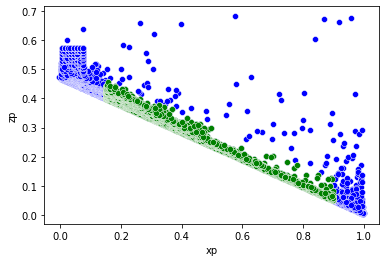

In [4]:
frame = 48

df = pd.DataFrame(data={
    'xp': pData[4,:,frame],
    'yp': pData[2,:,frame],
    'zp': pData[3,:,frame],
    'SE_a': pData[11,:,frame],
    'SE_b': pData[12,:,frame],
    'SE_c': pData[13,:,frame],
    'q0': pData[16,:,frame],
    'q1': pData[17,:,frame],
    'q2': pData[18,:,frame],
    'q3': pData[19,:,frame]})
df = df[df.SE_a != 0]
sns.scatterplot(x='xp', y='zp', data=df, color='b')

df.drop(df[df.xp < 0.15].index, inplace=True)
df.drop(df[df.xp > 0.9].index, inplace=True)
df.drop(df[df.zp > 0.5].index, inplace=True)


fit = np.polyfit(df.xp, df.zp, 1)+0.04
fit_fn = np.poly1d(fit)+0.04
m,b = fit
print("slope: ",m," intercept: ",b)

df.drop(df[df.zp > m*df.xp+b].index, inplace=True)
sns.scatterplot(x="xp", y="zp", data=df, color = 'g');


# Average Euler Angles

In [ ]:
def averageEuler_np(angle, bin_num):
    
    r_z,r_y,r_x=[],[],[]
    for i in range(len(df['q0'])):
        r = np.quaternion(df.q0.iloc[i], df.q1.iloc[i], df.q2.iloc[i], df.q3.iloc[i])
        f = np.rad2deg(quaternion.as_euler_angles(r))
        r_z.append(f[0])
        r_y.append(f[1])
        r_x.append(f[2])

    df['r_z'] = r_z
    df['r_y'] = r_y
    df['r_x'] = r_x

    SE_a_vals = df.SE_a.unique()
    SE_a_1 = df[df.SE_a == SE_a_vals[0]]
    SE_a_2 = df[df.SE_a == SE_a_vals[1]]

    #Bins and calculating average angles

    if angle == 'x':
        y_bins,bin_edges,misc = bstat(SE_a_1['xp'], SE_a_1['r_x'], statistic = 'mean', bins = bin_num)
        std, bin_edges,misc = bstat(SE_a_1['xp'], SE_a_1['r_x'], statistic = 'std', bins = bin_num)
        y_bins2,bin_edges,misc = bstat(SE_a_2['xp'], SE_a_2['r_x'], statistic = 'mean', bins = bin_num)
        std2, bin_edges,misc = bstat(SE_a_2['xp'], SE_a_2['r_x'], statistic = 'std', bins = bin_num)

    if angle == 'y':
        y_bins,bin_edges,misc = bstat(SE_a_1['xp'], SE_a_1['r_y'], statistic = 'mean', bins = bin_num)
        y_bins2,bin_edges,misc = bstat(SE_a_2['xp'], SE_a_2['r_y'], statistic = 'mean', bins = bin_num)
        std, bin_edges,misc = bstat(SE_a_1['xp'], SE_a_1['r_y'], statistic = 'std', bins = bin_num)
        std2, bin_edges,misc = bstat(SE_a_2['xp'], SE_a_2['r_y'], statistic = 'std', bins = bin_num)

    if angle == 'z':
        y_bins,bin_edges,misc = bstat(SE_a_1['xp'], SE_a_1['r_z'], statistic = 'mean', bins = bin_num)
        std, bin_edges,misc = bstat(SE_a_1['xp'], SE_a_1['r_z'], statistic = 'std', bins = bin_num)
        y_bins2,bin_edges,misc = bstat(SE_a_2['xp'], SE_a_2['r_z'], statistic = 'mean', bins = bin_num)
        std2, bin_edges,misc = bstat(SE_a_2['xp'], SE_a_2['r_z'], statistic = 'std', bins = bin_num)

    #Total Mean
    
    #Figure    
    x_bins = (bin_edges[:-1]+bin_edges[1:])/2

    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    ax1.plot(x_bins, y_bins, label='First Group -- Disks', color='blue')
    ax1.plot(x_bins, y_bins2, label='Second Group -- Rods', color='orange')
    
    ax1.plot(x_bins, y_bins+std, label='Std -- Disks', color='blue', linestyle='dashed',alpha=0.3)
    ax1.plot(x_bins, y_bins-std, label='Std -- Disks', color='blue', linestyle='dashed',alpha=0.3)
    ax1.plot(x_bins, y_bins2+std2, label='Std -- Rods', color='orange', linestyle='dashed',alpha=0.3)
    ax1.plot(x_bins, y_bins2-std2, label='Std -- Rods', color='orange', linestyle='dashed',alpha=0.3)

#     pylab.plot(x_bins, y_bins)
    pylab.ylim(-180,180)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    return plt.show()

In [17]:
def averageEuler_sci(angle, bin_num):
    
    r_z,r_y,r_x=[],[],[]
    for i in range(len(df['q0'])):
        r = R.from_quat([df.q0.iloc[i], df.q1.iloc[i], df.q2.iloc[i], df.q3.iloc[i]])
        f = r.as_euler('zyx', degrees = True)
        r_z.append(f[0])
        r_y.append(f[1])
        r_x.append(f[2])

    df['r_z'] = r_z
    df['r_y'] = r_y
    df['r_x'] = r_x

    SE_a_vals = df.SE_a.unique()
    SE_a_1 = df[df.SE_a == SE_a_vals[0]]
    SE_a_2 = df[df.SE_a == SE_a_vals[1]]

    #Bins and calculating average angles

    if angle == 'x':
        y_bins,bin_edges,misc = bstat(SE_a_1['xp'], SE_a_1['r_x'], statistic = 'mean', bins = bin_num)
        std, bin_edges,misc = bstat(SE_a_1['xp'], SE_a_1['r_x'], statistic = 'std', bins = bin_num)
        y_bins2,bin_edges,misc = bstat(SE_a_2['xp'], SE_a_2['r_x'], statistic = 'mean', bins = bin_num)
        std2, bin_edges,misc = bstat(SE_a_2['xp'], SE_a_2['r_x'], statistic = 'std', bins = bin_num)

    if angle == 'y':
        y_bins,bin_edges,misc = bstat(SE_a_1['xp'], SE_a_1['r_y'], statistic = 'mean', bins = bin_num)
        y_bins2,bin_edges,misc = bstat(SE_a_2['xp'], SE_a_2['r_y'], statistic = 'mean', bins = bin_num)
        std, bin_edges,misc = bstat(SE_a_1['xp'], SE_a_1['r_y'], statistic = 'std', bins = bin_num)
        std2, bin_edges,misc = bstat(SE_a_2['xp'], SE_a_2['r_y'], statistic = 'std', bins = bin_num)

    if angle == 'z':
        y_bins,bin_edges,misc = bstat(SE_a_1['xp'], SE_a_1['r_z'], statistic = 'mean', bins = bin_num)
        std, bin_edges,misc = bstat(SE_a_1['xp'], SE_a_1['r_z'], statistic = 'std', bins = bin_num)
        y_bins2,bin_edges,misc = bstat(SE_a_2['xp'], SE_a_2['r_z'], statistic = 'mean', bins = bin_num)
        std2, bin_edges,misc = bstat(SE_a_2['xp'], SE_a_2['r_z'], statistic = 'std', bins = bin_num)

    #Total Mean
    
    #Figure    
    x_bins = (bin_edges[:-1]+bin_edges[1:])/2

    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    ax1.plot(x_bins, y_bins, label='First Group -- Disks', color='blue')
    ax1.plot(x_bins, y_bins2, label='Second Group -- Rods', color='orange')
    
    ax1.plot(x_bins, y_bins+std, label='Std -- Disks', color='blue', linestyle='dashed',alpha=0.3)
    ax1.plot(x_bins, y_bins-std, label='Std -- Disks', color='blue', linestyle='dashed',alpha=0.3)
    ax1.plot(x_bins, y_bins2+std2, label='Std -- Rods', color='orange', linestyle='dashed',alpha=0.3)
    ax1.plot(x_bins, y_bins2-std2, label='Std -- Rods', color='orange', linestyle='dashed',alpha=0.3)

#     pylab.plot(x_bins, y_bins)
    pylab.ylim(-180,180)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    return plt.show()

In [ ]:
averageEuler_np('z',25)
averageEuler_np('y',25)
averageEuler_np('x',25)
averageEuler_sci('z',25)
averageEuler_sci('y',25)
averageEuler_sci('x',25)

# PDF One Bin

In [5]:
def OneKDE_np(bin_num, b, p):
    
    # Create a Dataframe and Cleanup
    q, r_angles, r_matrix = [],[],[]
    r_z, r_y, r_x = [],[],[]
    for i in range(len(df['q0'])):
        r = np.quaternion(df.q0.iloc[i], df.q1.iloc[i], df.q2.iloc[i], df.q3.iloc[i])
        f = np.rad2deg(quaternion.as_euler_angles(r))
        r_z.append(f[0])
        r_y.append(f[1])
        r_x.append(f[2])

    df['r_z'] = r_z
    df['r_y'] = r_y
    df['r_x'] = r_x

    SE_a_vals = df.SE_a.unique()
    df_d = df[df.SE_a == SE_a_vals[p]]
#     df_r = df[df.SE_a == SE_a_vals[1]]

    #Divide Dataframe into bins
    df_d = df_d.sort_values(by=['xp'])

    df_d['bin'] = pd.cut(df_d.xp, bin_num, include_lowest = True)# create bins

    group = df_d.groupby('bin')# group on bin

    dfs = [group.get_group(x) for x in group.groups]# list comprehension to split groups into list of dataframes 

    #Plot the PDFS
    fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(2, 3, figsize = (15,8))

    plt.suptitle('KDE: One bin!', color='black')
    ax1.set_xlim([-400,400])
    ax2.set_xlim([-400,400])
    ax3.set_xlim([-400,400])
    ax4.set_xlim([-400,400])
    ax5.set_xlim([-400,400])
    ax6.set_xlim([-400,400])
    # ax1.set_ylim([0,0.02])
    # ax2.set_ylim([0,0.02])
    # ax3.set_ylim([0,0.02])

  
    dfs[b]['r_z'].hist(ax=ax1)
    dfs[b]['r_y'].hist(ax=ax2)
    dfs[b]['r_x'].hist(ax=ax3)
    dfs[b]['r_z'].plot.density(ax=ax4)
    dfs[b]['r_y'].plot.density(ax=ax5)
    dfs[b]['r_x'].plot.density(ax=ax6)
    
    # sns.kdeplot(data=df_d, x="r_x")
    # df['r_x'].plot.density(label='pandas density', lw=2)
    return plt.show()

In [10]:
def OneKDE_sci(bin_num, b, p):
    
    # Create a Dataframe and Cleanup
    q, r_angles, r_matrix = [],[],[]
    r_z, r_y, r_x = [],[],[]
    for i in range(len(df['q0'])):
        r = R.from_quat([df.q0.iloc[i], df.q1.iloc[i], df.q2.iloc[i], df.q3.iloc[i]])
        f = r.as_euler('zyx', degrees = True)
        r_z.append(f[0])
        r_y.append(f[1])
        r_x.append(f[2])

    df['r_z'] = r_z
    df['r_y'] = r_y
    df['r_x'] = r_x

    SE_a_vals = df.SE_a.unique()
    df_d = df[df.SE_a == SE_a_vals[p]]
#     df_r = df[df.SE_a == SE_a_vals[1]]

    #Divide Dataframe into bins
    df_d = df_d.sort_values(by=['xp'])

    df_d['bin'] = pd.cut(df_d.xp, bin_num, include_lowest = True)# create bins

    group = df_d.groupby('bin')# group on bin

    dfs = [group.get_group(x) for x in group.groups]# list comprehension to split groups into list of dataframes 

    #Plot the PDFS
    fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(2, 3, figsize = (15,8))

    plt.suptitle('KDE: One bin!', color='black')
    ax1.set_xlim([-400,400])
    ax2.set_xlim([-400,400])
    ax3.set_xlim([-400,400])
    ax4.set_xlim([-400,400])
    ax5.set_xlim([-400,400])
    ax6.set_xlim([-400,400])
    # ax1.set_ylim([0,0.02])
    # ax2.set_ylim([0,0.02])
    # ax3.set_ylim([0,0.02])

  
    dfs[b]['r_z'].hist(ax=ax1)
    dfs[b]['r_y'].hist(ax=ax2)
    dfs[b]['r_x'].hist(ax=ax3)
    dfs[b]['r_z'].plot.density(ax=ax4)
    dfs[b]['r_y'].plot.density(ax=ax5)
    dfs[b]['r_x'].plot.density(ax=ax6)
    
    # sns.kdeplot(data=df_d, x="r_x")
    # df['r_x'].plot.density(label='pandas density', lw=2)
    return plt.show()

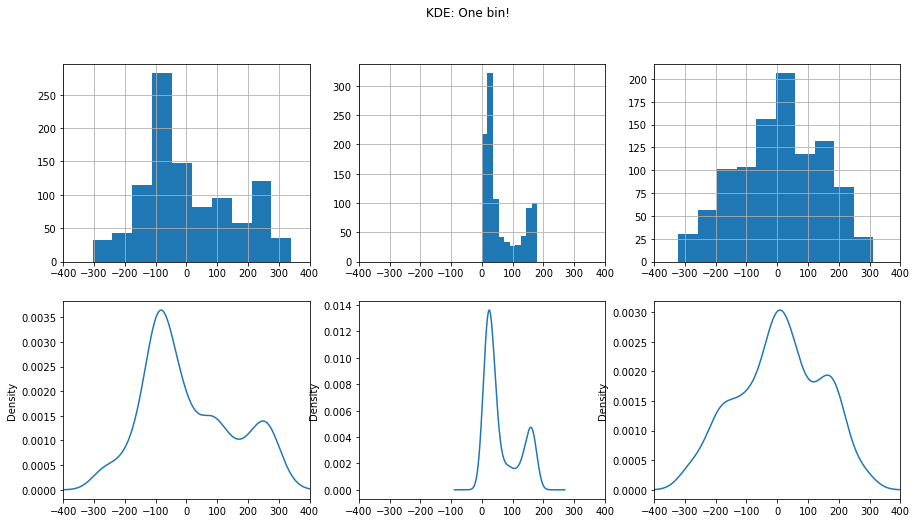

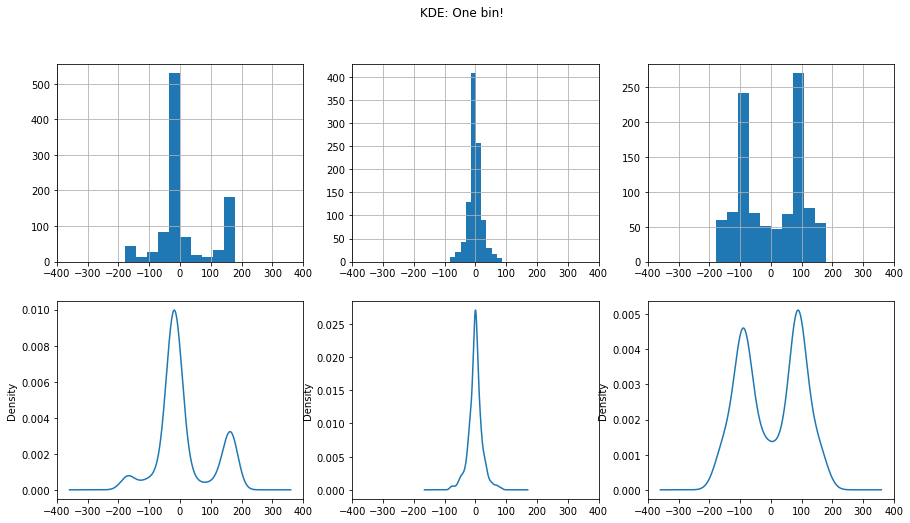

In [11]:
OneKDE_np(10,0,0)
OneKDE_sci(10,0,0)

# PDF Multiple Bins

In [12]:
def MultipleKDE_np(bin_num):
    
    # Create a Dataframe and Cleanup
    q, r_angles, r_matrix = [],[],[]
    r_z, r_y, r_x = [],[],[]
    for i in range(len(df['q0'])):
        r = np.quaternion(df.q0.iloc[i], df.q1.iloc[i], df.q2.iloc[i], df.q3.iloc[i])
        f = np.rad2deg(quaternion.as_euler_angles(r))
        r_z.append(f[0])
        r_y.append(f[1])
        r_x.append(f[2])

    df['r_z'] = r_z
    df['r_y'] = r_y
    df['r_x'] = r_x

    SE_a_vals = df.SE_a.unique()
    df_d = df[df.SE_a == SE_a_vals[0]]
    df_r = df[df.SE_a == SE_a_vals[1]]
    dd_mean_x= df_d.r_x.mean()
    dd_mean_y= df_d.r_y.mean()
    dd_mean_z= df_d.r_z.mean()
    dr_mean_x= df_r.r_x.mean()
    dr_mean_y= df_r.r_y.mean()
    dr_mean_z= df_r.r_z.mean()
    
    #Divide Dataframe into bins
    df_d = df_d.sort_values(by=['xp'])
    df_r = df_r.sort_values(by=['xp'])

    df_d['bin'] = pd.cut(df_d.xp, bin_num, include_lowest = True)# create bins
    df_r['bin'] = pd.cut(df_r.xp, bin_num, include_lowest = True)# create bins

    group = df_d.groupby('bin')# group on bin
    group_2 = df_r.groupby('bin')# group on bin

    dfs_d = [group.get_group(x) for x in group.groups]# list comprehension to split groups into list of dataframes 
    dfs_r = [group_2.get_group(x) for x in group_2.groups]# list comprehension to split groups into list of dataframes 

    #Plot the PDFS
    fig, [[ax1, ax2, ax3],[ax4,ax5,ax6]] = plt.subplots(2, 3, figsize = (15,8))

    plt.suptitle('KDE: Multiple bins!', color='black')
    ax1.set_xlim([-400,400])
    ax2.set_xlim([-400,400])
    ax3.set_xlim([-400,400])
    ax4.set_xlim([-400,400])
    ax5.set_xlim([-400,400])
    ax6.set_xlim([-400,400])
    # ax1.set_ylim([0,0.02])
    # ax2.set_ylim([0,0.02])
    # ax3.set_ylim([0,0.02])

    for i in range(bin_num):
        dfs_d[i]['r_z'].plot.density(ax=ax1)
        dfs_d[i]['r_y'].plot.density(ax=ax2)
        dfs_d[i]['r_x'].plot.density(ax=ax3)
        dfs_r[i]['r_z'].plot.density(ax=ax4)
        dfs_r[i]['r_y'].plot.density(ax=ax5)
        dfs_r[i]['r_x'].plot.density(ax=ax6)    
        
    # fig.text(0.04, 0.5, 'common Y', va='center', rotation='vertical')
    # sns.kdeplot(data=df_d, x="r_x")
    # df['r_x'].plot.density(label='pandas density', lw=2)
    
    return plt.show(), print('The Disk Mean (zyx):', dd_mean_z, dd_mean_y, dd_mean_x, '\nThe Rod Mean (zyx):', dr_mean_z, dr_mean_y, dr_mean_z)

In [ ]:
def MultipleKDE_sci(bin_num):
    
    # Create a Dataframe and Cleanup
    q, r_angles, r_matrix = [],[],[]
    r_z, r_y, r_x = [],[],[]
    for i in range(len(df['q0'])):
        r = R.from_quat([df.q0.iloc[i], df.q1.iloc[i], df.q2.iloc[i], df.q3.iloc[i]])
        f = r.as_euler('zyx', degrees = True)
        r_z.append(f[0])
        r_y.append(f[1])
        r_x.append(f[2])

    df['r_z'] = r_z
    df['r_y'] = r_y
    df['r_x'] = r_x

    SE_a_vals = df.SE_a.unique()
    df_d = df[df.SE_a == SE_a_vals[0]]
    df_r = df[df.SE_a == SE_a_vals[1]]
    dd_mean_x= df_d.r_x.mean()
    dd_mean_y= df_d.r_y.mean()
    dd_mean_z= df_d.r_z.mean()
    dr_mean_x= df_r.r_x.mean()
    dr_mean_y= df_r.r_y.mean()
    dr_mean_z= df_r.r_z.mean()
    
    #Divide Dataframe into bins
    df_d = df_d.sort_values(by=['xp'])
    df_r = df_r.sort_values(by=['xp'])

    df_d['bin'] = pd.cut(df_d.xp, bin_num, include_lowest = True)# create bins
    df_r['bin'] = pd.cut(df_r.xp, bin_num, include_lowest = True)# create bins

    group = df_d.groupby('bin')# group on bin
    group_2 = df_r.groupby('bin')# group on bin

    dfs_d = [group.get_group(x) for x in group.groups]# list comprehension to split groups into list of dataframes 
    dfs_r = [group_2.get_group(x) for x in group_2.groups]# list comprehension to split groups into list of dataframes 

    #Plot the PDFS
    fig, [[ax1, ax2, ax3],[ax4,ax5,ax6]] = plt.subplots(2, 3, figsize = (15,8))

    plt.suptitle('KDE: Multiple bins!', color='black')
    ax1.set_xlim([-400,400])
    ax2.set_xlim([-400,400])
    ax3.set_xlim([-400,400])
    ax4.set_xlim([-400,400])
    ax5.set_xlim([-400,400])
    ax6.set_xlim([-400,400])
    # ax1.set_ylim([0,0.02])
    # ax2.set_ylim([0,0.02])
    # ax3.set_ylim([0,0.02])

    for i in range(bin_num):
        dfs_d[i]['r_z'].plot.density(ax=ax1)
        dfs_d[i]['r_y'].plot.density(ax=ax2)
        dfs_d[i]['r_x'].plot.density(ax=ax3)
        dfs_r[i]['r_z'].plot.density(ax=ax4)
        dfs_r[i]['r_y'].plot.density(ax=ax5)
        dfs_r[i]['r_x'].plot.density(ax=ax6)    
        
    # fig.text(0.04, 0.5, 'common Y', va='center', rotation='vertical')
    # sns.kdeplot(data=df_d, x="r_x")
    # df['r_x'].plot.density(label='pandas density', lw=2)
    
    return plt.show(), print('The Disk Mean (zyx):', dd_mean_z, dd_mean_y, dd_mean_x, '\nThe Rod Mean (zyx):', dr_mean_z, dr_mean_y, dr_mean_z)

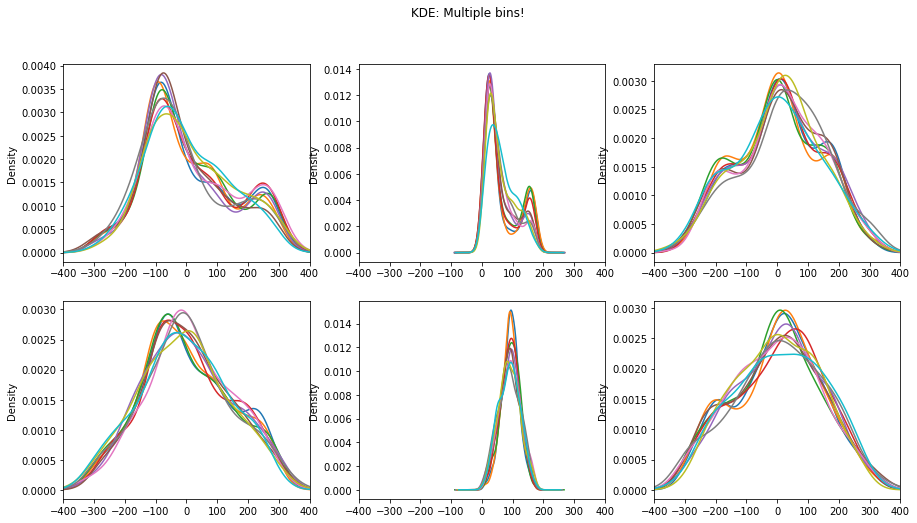

The Disk Mean (zyx): 5.160452875947361 62.12994394380081 6.113659086516835 
The Rod Mean (zyx): 1.0042954198985188 91.65550148427386 1.0042954198985188


NameError: name 'MultipleKDE_sci' is not defined

In [13]:
MultipleKDE_np(10)
MultipleKDE_sci(10)

# One Particle Rotating

Some Particles have a constant quaternion --- therefore no omega x, z, y

In [16]:
particle=14
particle_id = 14

df = pd.DataFrame(data={
    'xp': pData[4,particle, :],
    'yp': pData[2,particle,:],
    'zp':pData[3,particle,:],
    'SE_a': pData[11,particle, :],
    'omgx': pData[8,particle,:],
    'omgz': pData[9,particle,:],
    'omgy': pData[10,particle,:],
    'q0': pData[16,particle,:],
    'q1': pData[17,particle,:],
    'q2': pData[18,particle,:],
    'q3': pData[19,particle,:]})

import numpy as np
from mayavi import mlab


x, y, z = np.ogrid[-0.009:0.009:100j, -0.005:0.005:100j, -0.005:0.005:100j]
particle_id = 14
s, t = 2, 8

@mlab.animate(delay=500)
def anim():
    for frame in range(48):
        a, b, c = pData[11,particle_id,frame], pData[12,particle_id,frame], pData[13,particle_id,frame]
        q0 = pData[16, particle_id, frame]
        q1 = pData[17, particle_id, frame]
        q2 = pData[18, particle_id, frame]
        q3 = pData[19, particle_id, frame]
        q = Quaternion(q0,q1,q2,q3)
        R = q.rotation_matrix
        
        x_0,y_0,z_0=0,0,0
        F_r = ((((R[0][0]*(x-x_0)+R[1][0]*(y-y_0)+R[2][0]*(z-z_0))/a)**s) + (((R[0][1]*(x-x_0)+R[1][1]*(y-y_0)+R[2][1]*(z-z_0))/b)**s))**(s/t)+(((R[0][2]*(x-x_0)+R[1][2]*(y-y_0)+R[2][2]*(z-z_0))/c)**t)-1
        mlab.contour3d(F_r, contours = [0], color=(0.2, 0.4, 0.5), transparent = True)
        time.sleep(10)
        mlab.clf()
        yield

anim()
mlab.axes()
mlab.outline()
mlab.show()


Current object is not active, please select an active object.
Exception occurred in traits notification handler for object: <mayavi.tools.decorations.Axes object at 0x000001EB6B37E2C0>, trait: extent, old value: [0 0 0 0 0 0], new value: [39.2765274  61.7234726  36.49731445 64.50268555 30.57162476 70.42837524]
Traceback (most recent call last):
  File "C:\Users\emmye\anaconda3\lib\site-packages\traits\trait_notifiers.py", line 342, in __call__
    self.handler(*args)
  File "C:\Users\emmye\anaconda3\lib\site-packages\mayavi\tools\decorations.py", line 373, in _extent_changed
    dsh = DataSetHelper(axes.module_manager.source.outputs[0])
AttributeError: 'NoneType' object has no attribute 'source'
Current object is not active, please select an active object.


In [ ]:
from mayavi import mlab
f = mlab.figure()
f.scene.movie_maker.record = True
mlab.test_mesh_sphere_anim()

In [ ]:
particle=14
particle_id = 14

df = pd.DataFrame(data={
    'xp': pData[4,particle, :],
    'yp': pData[2,particle,:],
    'zp':pData[3,particle,:],
    'SE_a': pData[11,particle, :],
    'omgx': pData[8,particle,:],
    'omgz': pData[9,particle,:],
    'omgy': pData[10,particle,:],
    'q0': pData[16,particle,:],
    'q1': pData[17,particle,:],
    'q2': pData[18,particle,:],
    'q3': pData[19,particle,:]})

import numpy as np
from mayavi import mlab
import time

x, y, z = np.ogrid[-0.009:0.009:100j, -0.005:0.005:100j, -0.005:0.005:100j]
particle_id = 14
s, t = 2, 8
frame = 0

a, b, c = pData[11,particle_id,frame], pData[12,particle_id,frame], pData[13,particle_id,frame]
q0 = pData[16, particle_id, frame]
q1 = pData[17, particle_id, frame]
q2 = pData[18, particle_id, frame]
q3 = pData[19, particle_id, frame]
q = Quaternion(q0,q1,q2,q3)
R = q.rotation_matrix
    
x_0,y_0,z_0=0,0,0
x, y, z = np.ogrid[-0.005:0.005:100j, -0.005:0.005:100j, -0.005:0.005:100j]
scalars = ((((R[0][0]*(x-x_0)+R[1][0]*(y-y_0)+R[2][0]*(z-z_0))/a)**s) + (((R[0][1]*(x-x_0)+R[1][1]*(y-y_0)+R[2][1]*(z-z_0))/b)**s))**(s/t)+(((R[0][2]*(x-x_0)+R[1][2]*(y-y_0)+R[2][2]*(z-z_0))/c)**t)-1
iso = mlab.contour3d(scalars,contours=[0],color=(0.2, 0.4, 0.5), transparent=True)

for frame in range(1, 10):
    a, b, c = pData[11,particle_id,frame], pData[12,particle_id,frame], pData[13,particle_id,frame]
    q0 = pData[16, particle_id, frame]
    q1 = pData[17, particle_id, frame]
    q2 = pData[18, particle_id, frame]
    q3 = pData[19, particle_id, frame]
    q = Quaternion(q0,q1,q2,q3)
    R = q.rotation_matrix

    x_0,y_0,z_0=0,0,0
    scalars = ((((R[0][0]*(x-x_0)+R[1][0]*(y-y_0)+R[2][0]*(z-z_0))/a)**s) + (((R[0][1]*(x-x_0)+R[1][1]*(y-y_0)+R[2][1]*(z-z_0))/b)**s))**(s/t)+(((R[0][2]*(x-x_0)+R[1][2]*(y-y_0)+R[2][2]*(z-z_0))/c)**t)-1
    iso.mlab_source.scalars = scalars
    time.sleep(10)


In [ ]:
from mayavi.api import Engine
from mayavi import mlab
f = mlab.figure() # Returns the current scene.
e = mlab.get_engine() # Returns the running mayavi engine.
e.start()
s = e.new_scene()
from mayavi.sources.api import ParametricSurface
p = ParametricSurface()
e.add_source(p) # calls p.start internally.
p.remove() # Removes p from the engine.

In [ ]:
import time
import numpy as np
from mayavi import mlab

particle_id = 14
frame = 0
a, b, c = pData[11,particle_id,frame], pData[12,particle_id,frame], pData[13,particle_id,frame]
s, t = 2, 8
q0 = pData[16, particle_id, frame]
q1 = pData[17, particle_id, frame]
q2 = pData[18, particle_id, frame]
q3 = pData[19, particle_id, frame]
q = Quaternion(q0,q1,q2,q3)
R = q.rotation_matrix
    
x_0,y_0,z_0=0,0,0
x, y, z = np.ogrid[-0.005:0.005:100j, -0.005:0.005:100j, -0.005:0.005:100j]
F_r = ((((R[0][0]*(x-x_0)+R[1][0]*(y-y_0)+R[2][0]*(z-z_0))/a)**s) + (((R[0][1]*(x-x_0)+R[1][1]*(y-y_0)+R[2][1]*(z-z_0))/b)**s))**(s/t)+(((R[0][2]*(x-x_0)+R[1][2]*(y-y_0)+R[2][2]*(z-z_0))/c)**t)-1
s = mlab.contour3d(F_r,contours=[0],color=(0.2, 0.4, 0.5))



@mlab.animate(delay=100)
def anim():
    for i in range(10):
        a, b, c = pData[11,particle_id,i], pData[12,particle_id,i], pData[13,particle_id,i]
        q0 = pData[16, particle_id, i]
        q1 = pData[17, particle_id, i]
        q2 = pData[18, particle_id, i]
        q3 = pData[19, particle_id, i]
        q = Quaternion(q0,q1,q2,q3)
        R = q.rotation_matrix
        
        x_0,y_0,z_0=0,0,0
        F_r = ((((R[0][0]*(x-x_0)+R[1][0]*(y-y_0)+R[2][0]*(z-z_0))/a)**s) + (((R[0][1]*(x-x_0)+R[1][1]*(y-y_0)+R[2][1]*(z-z_0))/b)**s))**(s/t)+(((R[0][2]*(x-x_0)+R[1][2]*(y-y_0)+R[2][2]*(z-z_0))/c)**t)-1
        s.mlab_source.scalars = F_r
        yield
anim()  
# mlab.axes()
# mlab.outline()
# mlab.show()    
